In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import re
import shutil
import string

from wordcloud import WordCloud
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import re

from pandarallel import pandarallel
import multiprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/egehanyorulmaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/egehanyorulmaz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/egehanyorulmaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [23]:
TRAIN_JSONL_PATH = "data_raw/train.jsonl"
EVAL_JSONL_PATH = "data_raw/dev.jsonl"
TEST_JSONL_PATH = "data_raw/test.jsonl"

In [24]:
from helper.utils import read_jsonl

train = read_jsonl(TRAIN_JSONL_PATH)
eval = read_jsonl(EVAL_JSONL_PATH)
test = read_jsonl(TEST_JSONL_PATH)

In [25]:
dfs = [train, eval, test]

### Preprocessing

In [26]:
def expand_contractions(text):
    """
    Expands contractions in the input text using the contractions library
    and regular expressions.
    I've -> I have
    He's -> He is
    
    Args:
        text (str): The input text with contractions.
    
    Returns:
        str: The input text with contractions expanded.
    """
    # Use the contractions library to expand the contraction
    text_expanded = contractions.fix(text)

    # Use a regular expression to expand the contraction
    text_expanded_re = re.sub(r'\b(\w+)\'(\w+)\b', r"\1'\2", text_expanded)
    
    # Return the expanded text
    return text_expanded_re

for i, df in enumerate(dfs):
    df["modified_text"] = df["text"].parallel_apply(lambda t: expand_contractions(t))
    dfs[i] = df

In [27]:
def preprocess_text(text):
    """
    Preprocesses the input text by removing stopwords, punctuation, and
    lemmatizing the words.
    """
    # Convert text to lowercase
    text = text.lower()
    
    # Replace special characters with whitespace
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove leading and trailing whitespace
    text = text.strip()
    
    # Tokenize text into individual words
    words = nltk.word_tokenize(text)
    
    # Remove stopwords from the text
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize the words using WordNetLemmatizer
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]
    
    # Perform snowball stemming on the words
    # stemmer = SnowballStemmer("english")
    # words = [stemmer.stem(word) for word in words]
    
    # Join the preprocessed words back into a single string
    preprocessed_text = ' '.join(words)
    
    # Remove leading and trailing whitespace
    preprocessed_text = preprocessed_text.strip()
    
    return preprocessed_text

In [28]:
for i, df in enumerate(dfs):
    df["text"] = df["text"].parallel_apply(lambda t: preprocess_text(t))
    dfs[i] = df

Dataset:  train


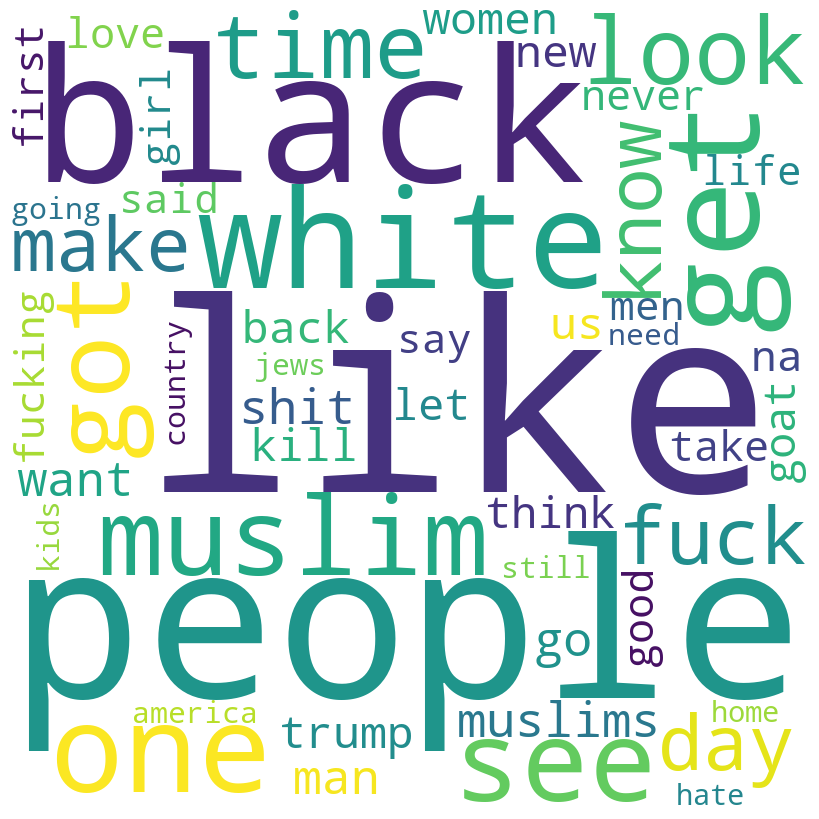

Dataset:  evaluation


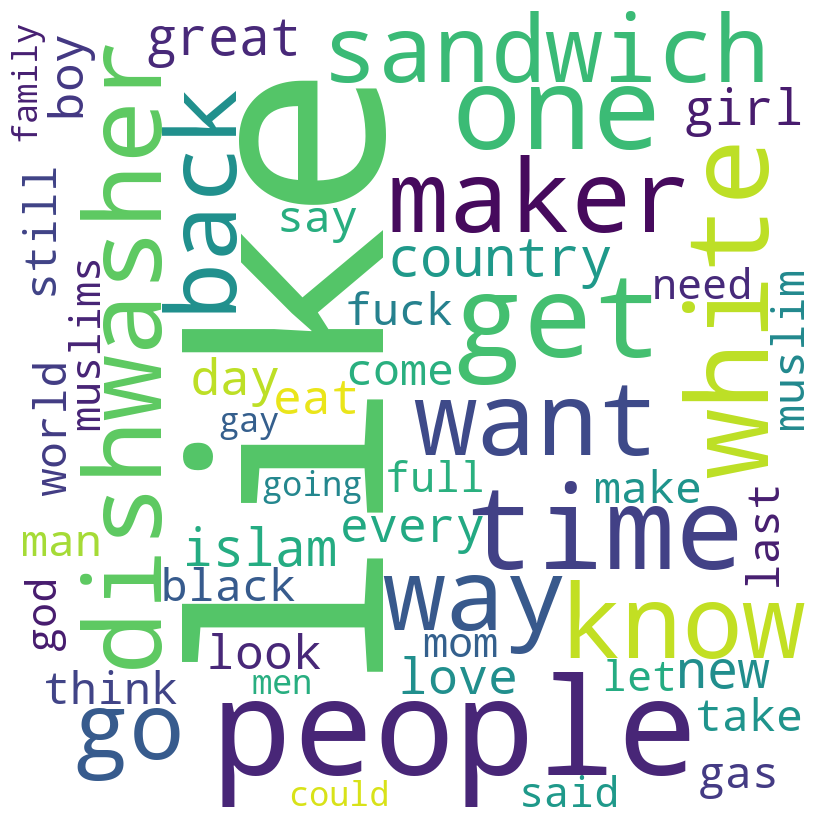

Dataset:  test


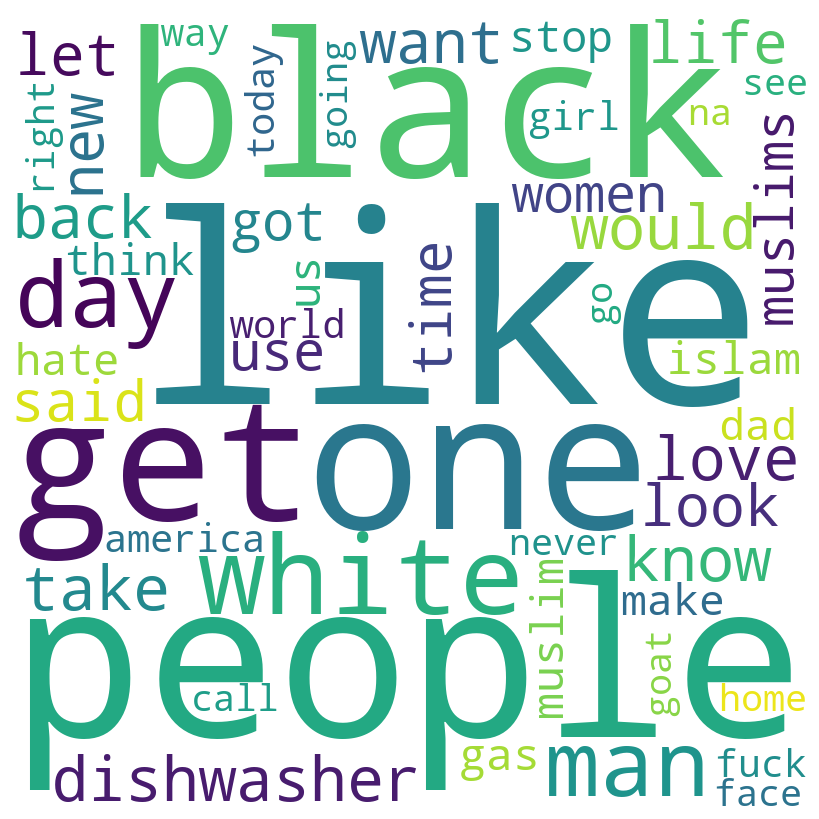

In [29]:
from collections import Counter

datasets = ["train", "evaluation", "test"]

for dataset, df in enumerate(dfs):
    print("Dataset: ", datasets[dataset])
    # Tokenize the preprocessed text into individual words
    words = " ".join(df["text"])
    words = nltk.word_tokenize(words)

    # Count the frequency of each word
    word_freq = Counter(words)

    # Create a WordCloud visualization of the most frequent words
    wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=50).generate_from_frequencies(word_freq)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

### Keras

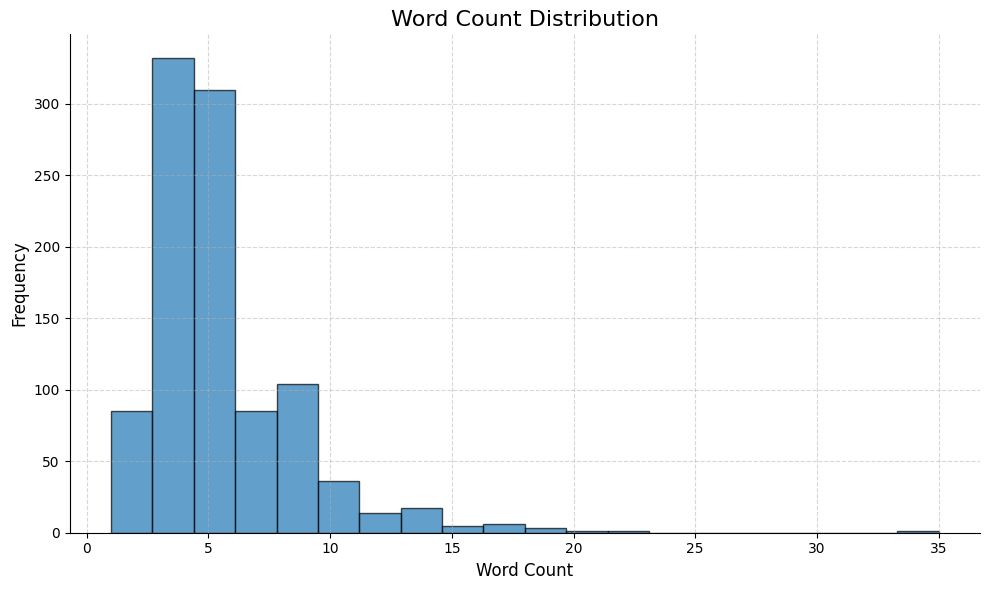

In [30]:
# Calculate word count for each text
word_counts = df["text"].apply(lambda t: len(t.split(" ")))

# Create the histogram plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(word_counts, bins=20, edgecolor="black", alpha=0.7)

# Set labels and title
ax.set_title("Word Count Distribution", fontsize=16)
ax.set_xlabel("Word Count", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
ax.tick_params(axis="both", labelsize=10)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

### FastText Word Embeddings

In [31]:
train['text'].to_csv('data_cache/train_data.txt', index=False, header=False)
train_ids = train['id'].to_numpy()
train_indices = train.index

eval['text'].to_csv('data_cache/eval_data.txt', index=False, header=False)
eval_ids = eval['id'].to_numpy()
eval_indices = eval.index

test['text'].to_csv('data_cache/test_data.txt', index=False, header=False)
test_ids = test['id'].to_numpy()
test_indices = test.index


In [32]:
%pip install fasttext

Note: you may need to restart the kernel to use updated packages.


### Getting the text embeddings

In [33]:
NUMBER_OF_EMBEDDING = 128

In [34]:
import fasttext

file_path = 'data_cache/train_data.txt'

def train_predict_embedding(file_path, df, indices, embedding_dimension=100):
    # Train FastText model
    model = fasttext.train_unsupervised(file_path, dim=embedding_dimension)  # Set desired embedding dimension (n=100 in this example)
    embedding_df = predict_embedding(df, indices, model)
    return embedding_df, model


def predict_embedding(df, indices, model):
    # Create an empty list to store the word embeddings
    embedding_list = []

    # Iterate over each row in the original DataFrame
    for index, row in df.iterrows():
        text = row['text']
        
        # Obtain the word embedding for the current text using FastText
        embedding = model.get_sentence_vector(text)
        
        # Append the embedding vector to the list
        embedding_list.append(embedding)

    # Create a DataFrame from the embedding list
    embedding_df = pd.DataFrame(embedding_list, index=indices)
    return embedding_df

train_embedding_df, train_model = train_predict_embedding(file_path, train, train_indices, embedding_dimension=NUMBER_OF_EMBEDDING)
eval_embedding_df = predict_embedding(eval, eval_indices, train_model)
test_embedding_df = predict_embedding(test, test_indices, train_model)

Read 0M words
Number of words:  2140
Number of labels: 0
Progress: 100.0% words/sec/thread:   99002 lr:  0.000000 avg.loss:  2.878953 ETA:   0h 0m 0s


In [35]:
print("Train shape:", train_embedding_df.shape)
print("Eval shape:", eval_embedding_df.shape)
print("Test shape:", test_embedding_df.shape)

Train shape: (8500, 128)
Eval shape: (500, 128)
Test shape: (1000, 128)


In [36]:
train_embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.194392,-0.118471,0.118298,0.056273,0.143183,-0.062431,0.040736,-0.005134,-0.086167,-0.022124,...,-0.025616,-0.005969,-0.001055,-0.012460,0.028007,0.214113,0.054780,0.050599,-0.241101,-0.009463
1,-0.194007,-0.113893,0.118640,0.062959,0.141988,-0.055513,0.039929,-0.008352,-0.086339,-0.015696,...,-0.030661,-0.005358,0.005619,-0.006257,0.026301,0.216965,0.047173,0.053664,-0.241820,-0.011685
2,-0.194261,-0.117995,0.121575,0.054900,0.142438,-0.061687,0.042550,-0.008370,-0.087584,-0.019589,...,-0.023758,-0.012939,-0.007185,-0.018086,0.022933,0.209522,0.060631,0.055674,-0.239266,-0.016370
3,-0.189937,-0.109185,0.119966,0.066259,0.140174,-0.049194,0.040299,-0.008522,-0.085329,-0.012418,...,-0.035768,-0.006671,0.011552,-0.003397,0.025926,0.217561,0.042518,0.054791,-0.244534,-0.011521
4,-0.187317,-0.106361,0.119413,0.070263,0.138763,-0.044444,0.038252,-0.010073,-0.084470,-0.010575,...,-0.039987,-0.002987,0.017813,0.002027,0.026734,0.220035,0.036520,0.053560,-0.244301,-0.010000


In [38]:
train_embedding_df.columns = [f"embedding_{i}" for i in range(NUMBER_OF_EMBEDDING)]
eval_embedding_df.columns = [f"embedding_{i}" for i in range(NUMBER_OF_EMBEDDING)]
test_embedding_df.columns = [f"embedding_{i}" for i in range(NUMBER_OF_EMBEDDING)]

In [39]:
train_df = pd.concat([train, train_embedding_df], axis=1)
eval_df = pd.concat([eval, eval_embedding_df], axis=1)
test_df = pd.concat([test, test_embedding_df], axis=1)

In [40]:
train_df

,id,img,label,text,modified_text,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,42953,img/42953.png,0,character color matters,its their character not their color that matters,-0.194392,-0.118471,0.118298,0.056273,0.143183,...,-0.025616,-0.005969,-0.001055,-0.012460,0.028007,0.214113,0.054780,0.050599,-0.241101,-0.009463
1,23058,img/23058.png,0,afraid love everyone like ex,do not be afraid to love again everyone is not...,-0.194007,-0.113893,0.118640,0.062959,0.141988,...,-0.030661,-0.005358,0.005619,-0.006257,0.026301,0.216965,0.047173,0.053664,-0.241820,-0.011685
2,13894,img/13894.png,0,putting bows pet,putting bows on your pet,-0.194261,-0.117995,0.121575,0.054900,0.142438,...,-0.023758,-0.012939,-0.007185,-0.018086,0.022933,0.209522,0.060631,0.055674,-0.239266,-0.016370
3,37408,img/37408.png,0,love everything everybody except squirrels hat...,i love everything and everybody! except for sq...,-0.189937,-0.109185,0.119966,0.066259,0.140174,...,-0.035768,-0.006671,0.011552,-0.003397,0.025926,0.217561,0.042518,0.054791,-0.244534,-0.011521
4,82403,img/82403.png,0,everybody loves chocolate chip cookies even hi...,"everybody loves chocolate chip cookies, even h...",-0.187317,-0.106361,0.119413,0.070263,0.138763,...,-0.039987,-0.002987,0.017813,0.002027,0.026734,0.220035,0.036520,0.053560,-0.244301,-0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants hang auschwitz,nobody wants to hang auschwitz me,-0.190026,-0.108083,0.120199,0.065972,0.138977,...,-0.034304,-0.006014,0.011135,-0.002876,0.024450,0.216823,0.043033,0.054737,-0.244682,-0.012501
8496,98203,img/98203.png,1,god grants child 20 years marriage israel bomb...,when god grants you a child after 20 years of ...,-0.194252,-0.118527,0.118889,0.057206,0.143693,...,-0.023626,-0.007750,0.000864,-0.013940,0.026789,0.215102,0.052581,0.053809,-0.239971,-0.008532
8497,36947,img/36947.png,1,gays social media equality body positivity lov...,gays on social media: equality! body positivit...,-0.193221,-0.114444,0.118941,0.060434,0.142332,...,-0.028777,-0.006855,0.004735,-0.008015,0.025588,0.216508,0.048245,0.053458,-0.241942,-0.009908
8498,16492,img/16492.png,1,bad day could siamese twin attached gay brothe...,having a bad day? you could be a siamese twin ...,-0.193953,-0.117891,0.119024,0.058779,0.144467,...,-0.025407,-0.006581,-0.000553,-0.011729,0.026508,0.214445,0.053485,0.053784,-0.240116,-0.011076


In [41]:
eval_df

,id,img,label,text,modified_text,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,8291,img/08291.png,1,white people shooting range,white people is this a shooting range,-0.194315,-0.117655,0.121635,0.054544,0.143391,...,-0.025456,-0.011819,-0.005229,-0.014771,0.024480,0.211778,0.058496,0.053549,-0.239473,-0.013280
1,46971,img/46971.png,1,bravery finest,bravery at its finest,-0.192153,-0.111347,0.117005,0.061419,0.141630,...,-0.027388,-0.004838,0.001844,-0.009542,0.026938,0.214994,0.048203,0.052397,-0.241574,-0.010046
2,3745,img/03745.png,1,order comes 37 50 white privilege discount bri...,your order comes to $37.50 and your white priv...,-0.160411,-0.113540,0.121344,0.064380,0.101691,...,-0.005644,-0.020171,0.003925,-0.011506,0.021108,0.161616,0.066612,0.029252,-0.203647,0.000168
3,83745,img/83745.png,1,time send parasites back desert,it is time.. to send these parasites back to t...,-0.193048,-0.116217,0.118724,0.059256,0.143735,...,-0.023183,-0.006869,0.000720,-0.012281,0.027291,0.215139,0.051291,0.055059,-0.240912,-0.010821
4,80243,img/80243.png,1,mississippi wind chime,mississippi wind chime,-0.190325,-0.114083,0.116708,0.055575,0.141692,...,-0.022492,-0.010359,-0.001196,-0.008360,0.025044,0.208883,0.052482,0.056310,-0.242367,-0.009526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,83675,img/83675.png,0,gon na like phelps one day,i am going to be like phelps one day,-0.195634,-0.118099,0.119181,0.059214,0.144130,...,-0.024093,-0.005145,-0.002407,-0.012965,0.026126,0.213643,0.053777,0.054299,-0.237642,-0.011713
496,37198,img/37198.png,0,relaxed feel go next level,when you are so relaxed you can feel yourself ...,-0.195560,-0.117952,0.119302,0.057999,0.143718,...,-0.024728,-0.007417,-0.000679,-0.012887,0.027492,0.215794,0.052321,0.052557,-0.239587,-0.010552
497,48670,img/48670.png,0,look sandwich maker club found wish clearance,look at this sandwich maker club i found on wi...,-0.195329,-0.117601,0.120510,0.058034,0.143974,...,-0.026056,-0.005245,0.002071,-0.010001,0.025981,0.216975,0.048296,0.053355,-0.240920,-0.010295
498,9863,img/09863.png,0,diverse group women,diverse group of women,-0.194465,-0.116503,0.118187,0.055801,0.145230,...,-0.023218,-0.006308,-0.003059,-0.013833,0.026818,0.213699,0.054575,0.053423,-0.240139,-0.010097


In [42]:
test_df

,id,img,text,modified_text,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,16395,img/16395.png,handjobs sold seperately,handjobs sold seperately,-0.194477,-0.119218,0.118211,0.054699,0.145121,-0.061925,...,-0.023601,-0.008676,-0.002876,-0.014232,0.027075,0.214370,0.054169,0.054061,-0.239424,-0.010102
1,37405,img/37405.png,introducing fidget spinner women,introducing fidget spinner for women,-0.194970,-0.117847,0.120061,0.055077,0.141742,-0.063311,...,-0.022867,-0.011166,-0.007468,-0.016089,0.022789,0.210354,0.058499,0.052615,-0.241006,-0.016604
2,94180,img/94180.png,happy pride month let go beat lesbians,happy pride month let us go beat up lesbians,-0.194322,-0.119082,0.119224,0.057695,0.144516,-0.064016,...,-0.022654,-0.007456,-0.002020,-0.015031,0.027555,0.214384,0.055850,0.053496,-0.239580,-0.010409
3,54321,img/54321.png,laughs majority u crime rate,laughs in [majority of you.s crime rate],-0.192273,-0.117840,0.119582,0.056992,0.146755,-0.062626,...,-0.024877,-0.009055,0.000958,-0.013933,0.028556,0.214214,0.053811,0.055823,-0.240207,-0.006951
4,97015,img/97015.png,finds 72 virgins goats,finds out those 72 virgins.. are goats,-0.192794,-0.113858,0.118643,0.061514,0.143367,-0.056539,...,-0.029095,-0.006898,0.004915,-0.009508,0.026657,0.217420,0.048204,0.052266,-0.241958,-0.010980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3869,img/03869.png,mother love child divine thing,a mother's love for the child is a divine thing,-0.193060,-0.115944,0.121642,0.057592,0.140575,-0.058669,...,-0.026492,-0.012778,-0.003299,-0.013190,0.021985,0.211518,0.056574,0.054211,-0.242540,-0.017220
996,23817,img/23817.png,sea monkeys,sea monkeys,-0.191122,-0.118699,0.118069,0.058730,0.143411,-0.060900,...,-0.022483,-0.005431,-0.002360,-0.014876,0.027069,0.214169,0.053984,0.055002,-0.241024,-0.008449
997,56280,img/56280.png,little miss muffet sat tuffet,little miss muffet sat on her tuffet,-0.195164,-0.116989,0.119699,0.055948,0.145838,-0.061374,...,-0.023185,-0.006459,-0.002249,-0.013289,0.026444,0.215173,0.053348,0.054634,-0.237719,-0.008899
998,29384,img/29384.png,row,they are in a row,-0.192183,-0.118440,0.120884,0.057170,0.146335,-0.063772,...,-0.027835,-0.007609,-0.001925,-0.014607,0.027285,0.214392,0.056416,0.054628,-0.238499,-0.007087


In [43]:
train_df.to_csv('data_preprocessed/train_embedding.csv', index=False)
eval_df.to_csv('data_preprocessed/eval_embedding.csv', index=False)
test_df.to_csv('data_preprocessed/test_embedding.csv', index=False)

In [46]:
from datetime import datetime

print("Last run date: ", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

Last run date:  23/05/2023 12:18:33
